In [18]:
import pygad
import numpy as np

In [19]:
def SEIR(r1, t, S0, E0, I_R0, I_H0, H_H0, R0):
    S = []
    E = []
    I_R = []
    I_H = []
    H_H = []
    R = []

    N = 24.89432*10**6
    r1 = r1/N
    beta1 = 0.251
    v = 1/3
    p_R = 0.998 
    p_H = 0.002 ##p_R+p_H=1
    gamma = 1/5
    sigma_H = 1/8

    T = t

    S_old = S0
    E_old = E0
    I_R_old = I_R0
    I_H_old = I_H0
    H_H_old = H_H0
    R_old = R0

    S = [S0]
    E = [E0]
    I_R = [I_R0]
    I_H = [I_H0]
    H_H = [H_H0]
    R = [R0]
    
    H_H_num = 0
    for i in range(T):
        S_new = S_old-r1*beta1*(I_R_old+I_H_old)*S_old
        E_new = E_old+r1*beta1*(I_R_old+I_H_old)*S_old-v*E_old
        I_R_new = I_R_old+p_R*v*E_old-gamma*I_R_old
        I_H_new = I_H_old+p_H*v*E_old-gamma*I_H_old
        H_H_new = H_H_old+gamma*I_H_old-sigma_H*H_H_old
        R_new = R_old+gamma*I_R_old+sigma_H*H_H_old
        
        S.append(S_new)
        E.append(E_new)
        I_R.append(I_R_new)
        I_H.append(I_H_new)
        H_H.append(H_H_new)
        R.append(R_new)
        H_H_num+=gamma*I_H_old
        #print('old:',S_old+E_old+I_R_old+I_H_old+I_C_old+H_H_old+H_C_old+C_old+R_old)
        #print('new:',S_new+E_new+I_R_new+I_H_new+I_C_new+H_H_new+H_C_new+C_new+R_new)
        S_old = int(S_new)
        E_old = int(E_new)
        I_R_old = int(I_R_new)
        I_H_old = int(I_H_new)
        H_H_old = int(H_H_new)
        R_old = int(R_new)
    return S, E, I_R, I_H, H_H, R, H_H_num


def mental_health_record(plan):
    record = []
    temp = 0
    for i in range(len(plan)):
        if plan[i] == 1:
            temp+=1
            if i == len(plan)-1:
                record.append(temp)
        elif plan[i] ==0:
            if temp != 0:
                record.append(temp)
            temp=0
    return record

def sigmoid(x):
    import math
    w = 1 ##sharpness
    b = -6 ##rate of day
    z = w*x+b
    return 1/(1+math.e**(-z))
def mental_health(plan, penalty):
    record = mental_health_record(plan)
    s = 0
    for x in record:
        s+=sigmoid(x)
    return penalty*s
def env(plan):
    r0 = 7.5    #non-lockdown rate
    r1 = 0.5   #lockdown rate
    S_all, E_all, I_R_all, I_H_all, H_H_all, R_all, H_H_num_all = [], [], [], [], [], [], 0
    S0, E0, I_R0, I_H0, H_H0, R0 = 24.89432*10**6-23-2,23 , 2, 0, 0, 0 ##intial value
    S, E, I_R, I_H, H_H, R, H_H_num = SEIR(r0, 5, S0, E0, I_R0, I_H0, H_H0, R0)
    S_all+=S
    E_all+=E
    I_R_all+=I_R
    I_H_all+=I_H
    H_H_all+=H_H
    R_all+=R
    H_H_num_all+=H_H_num
    for status in plan:
        S, E, I_R, I_H, H_H, R, H_H_num = SEIR(status * r1 + (1-status) * r0, 5, S[-1], E[-1], I_R[-1], I_H[-1], H_H[-1], R[-1])
        S_all+=S
        E_all+=E
        I_R_all+=I_R
        I_H_all+=I_H
        H_H_all+=H_H
        R_all+=R
        H_H_num_all+=H_H_num
    ##subject to change
    eco_parameter = 200
    mental_health_parameter = 1000
    H_H_parameter = 0.4
    left_parameter = 0.1/10000*1
    #############################3
    import math
    cost = eco_parameter*sum(plan) + mental_health(plan, mental_health_parameter) +\
                H_H_parameter*H_H_num_all +\
                math.e**(left_parameter*(E_all[-1]+I_R_all[-1]+I_H_all[-1]))
    return cost, (E_all[-1]+I_R_all[-1]+I_H_all[-1]), H_H_num_all

## Genetic Algorithm

In [20]:
def fitness_function(solution, solution_index):
    cost_value = env(solution)[0]
    return -cost_value

In [21]:
#TODO
num_generations = 500
num_parents_mating = 4

fitness_function = fitness_function

sol_per_pop = 8
num_genes = 12


parent_selection_type = 'sss'
keep_parent = 1

crossover_type = 'single_point'

mutation_type = 'random'
mutation_num_genes = 2

gene_space = {'low': 0, 'high':7.5}

In [186]:
GA = pygad.GA(num_generations=num_generations,
              num_parents_mating=num_parents_mating,
              sol_per_pop=sol_per_pop,
              num_genes=num_genes,
              fitness_func=fitness_function,
              parent_selection_type=parent_selection_type,
              keep_parents=keep_parent,
              crossover_type=crossover_type,
              mutation_type=mutation_type,
              mutation_num_genes=mutation_num_genes,
              gene_space=gene_space)

In [187]:
GA.run()

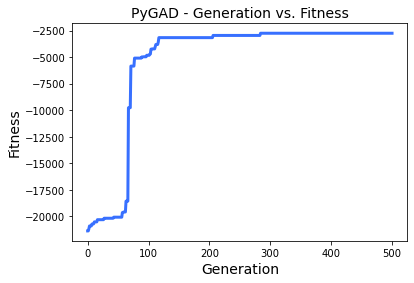

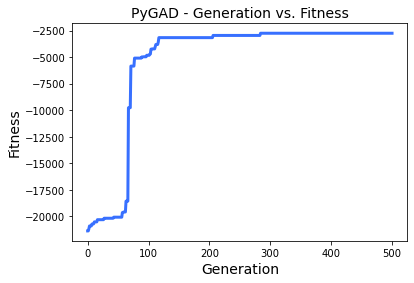

In [188]:
GA.plot_fitness()

In [189]:
solution, solution_fitness, solution_idx = GA.best_solution()

In [190]:
solution

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [182]:
solution_fitness

-1960.276897746718

In [92]:
sol = np.array([1]*9+[0]*(51))
env(sol)[0]

1853.5989268224332

## Find the Initial Values

In [12]:
real_I = np.array([2, 8, 16, 19, 28, 48, 55, 65, 80])
err_lst = []

for t in range(3, 9):
    min_err = float('inf')
    for r_1 in range(60, 220):
        r1 = r_1/10
        for E0 in range(10, 50):
            for I_R0 in range(1, 10):
                S0, I_R0, I_H0, H_H0, R0 = 24.89432*10**6-E0-2, I_R0, 0, 0, 0
                _, _, I_R, I_H, _, _, _ = SEIR(r1, t, S0, E0, I_R0, I_H0, H_H0, R0)
                err = np.sum((np.array(I_R) + np.array(I_H) - real_I[:t+1]) ** 2 / real_I[:t+1]**2)
                if err < min_err:
                    min_err = err
                    config = r1, E0, I_R0
    err_lst.append(min_err)
    print(f't = {t}, r = {config[0]}, E0 = {config[1]}, I_R0 ={config[2]}')

t = 3, r = 10.0, E0 = 21, I_R0 =2
t = 4, r = 6.4, E0 = 23, I_R0 =2
t = 5, r = 7.5, E0 = 23, I_R0 =2
t = 6, r = 6.4, E0 = 23, I_R0 =2
t = 7, r = 6.0, E0 = 23, I_R0 =2
t = 8, r = 6.0, E0 = 21, I_R0 =2


In [14]:
import matplotlib.pyplot as plt

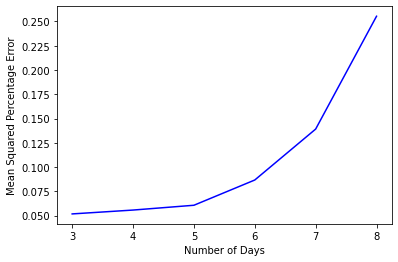

In [17]:
T = [i for i in range(3,9)]

plt.plot(T, err_lst, color='blue')
plt.xlabel('Number of Days')
plt.ylabel('Mean Squared Percentage Error')
plt.show()